# Moltbook Karma Data Engineering Pipeline

**Objetivo**: Pipeline de ingenieria de datos end-to-end para predecir el karma de usuarios en moltbook.com

**Variable Target**: `users.karma` (regresion)

**Base de datos**: PostgreSQL en AWS RDS

[![Python 3.10+](https://img.shields.io/badge/python-3.10+-blue.svg)](https://www.python.org/downloads/)
[![License: MIT](https://img.shields.io/badge/License-MIT-yellow.svg)](https://opensource.org/licenses/MIT)

![Moltbook Banner](../assets/banner.jpg)

Moltbook.com es una red social donde agentes de IA interactúan entre sí de forma autónoma: publican, comentan y votan. Lo interesante es que a veces discuten temas sensibles como vulnerabilidades de sistemas, lo cual genera preocupación sobre cómo estos bots pueden corromperse entre ellos.

Este proyecto nace de la necesidad de analizar el **karma** (la reputación de cada agente) para entender qué factores determinan la influencia dentro de la plataforma. Los hallazgos pueden servir para estrategias de seguridad y moderación en sistemas de IA.

Esta red social esta compuesta por:

**Entidades**:
- `users`: Perfiles de agentes
- `posts`: Publicaciones en comunidades
- `comments`: Comentarios en posts
- `sub_molt`: Comunidades tematicas
- `user_submolt`: Relacion muchos a muchos entre usuarios y comunidades

**Variable Objetivo**: 
- `karma` : puntuacion de reputacion del usuario

**Base de datos**: PostgreSQL en AWS RDS con esquema normalizado de 5 tablas

## 1. Configuracion del Entorno

En primer lugar configuramos el entorno de trabajo, importando las librerías y configurando el setup necesario para para el desarrollo del proyecto.

### 1.1 Imports y Setup

Se importan las librerías necesarias, se configura el path y se crean los directorios de trabajo.

In [79]:
import sys
from pathlib import Path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import logging
import polars as pl
from config.settings import settings

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
settings.ensure_directories()
print(f"Project root: {settings.project_root}")
print(f"Data directory: {settings.data_dir}")

Project root: c:\Users\Paulina Peralta\Desktop\moltbook-karma
Data directory: c:\Users\Paulina Peralta\Desktop\moltbook-karma\data


In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Configuracion global de estilos
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100
print('Visualization libraries loaded')

Visualization libraries loaded


## 2. Web Scraping con Playwright

Playwright es una herramienta de automatizacion de navegador que permite renderizar paginas web dinamicas (SPAs) como si fuera un usuario real. Para moltbook.com es necesario porque el contenido se carga con JavaScript y no se puede obtener con simples requests HTTP.

El proyecto implementa dos scrapers:
- **MoltbookScraper** (sincrono): scraper basico con una sola pagina de navegador
- **AsyncMoltbookScraper** (asincrono): scraper masivo con multiples workers en paralelo usando `asyncio`, capaz de recolectar cientos de miles de registros

### 2.1 Inicializacion de Base de Datos

Para ello en primer lugar inicializamos la base de datos. El sistema soporta PostgreSQL (produccion en AWS RDS) y SQLite (desarrollo local). La configuracion se controla mediante `settings.db_type`.

In [81]:
from src.database.connection import init_database, check_database_exists
from src.database.operations import DatabaseOperations
from src.database.models import User, Post, Comment, SubMolt

print(f"Database type: {settings.db_type}")

try:
    if not check_database_exists():
        print("Initializing database...")
        init_database()
    else:
        print("Database already exists")

    db_ops = DatabaseOperations()
    print(f"\nCurrent counts:")
    print(f"  Users:    {db_ops.count(User)}")
    print(f"  Posts:    {db_ops.count(Post)}")
    print(f"  Comments: {db_ops.count(Comment)}")
    print(f"  SubMolts: {db_ops.count(SubMolt)}")
except Exception as e:
    print(f"Database connection failed: {e}")
    print("If using PostgreSQL, ensure psycopg2 is installed and RDS is accessible.")
    print("You can still run the pipeline from Silver layer using existing Parquet files.")
    db_ops = None

2026-02-17 09:23:59,496 - WARNING - PostgreSQL connection check failed: No module named 'psycopg2'


Database type: postgres
Initializing database...
Database connection failed: No module named 'psycopg2'
If using PostgreSQL, ensure psycopg2 is installed and RDS is accessible.
You can still run the pipeline from Silver layer using existing Parquet files.


### 2.2 Ejecucion del Scraper

El scraping se ejecuta desde la CLI con dos modos:

**Modo sincrono** (`scrape`): usa un solo navegador y procesa secuencialmente. Util para pruebas rapidas.

**Modo asincrono masivo** (`scrape-massive`): usa multiples paginas de navegador en paralelo con `asyncio.Semaphore` para controlar la concurrencia. El flujo tiene 4 fases:
1. **Descubrimiento**: encuentra URLs de usuarios y submolts en paralelo
2. **Perfiles de usuario**: scrapea los perfiles con multiples workers
3. **Submolts + Posts + Comments**: scrapea cada submolt, sus posts y comentarios, con un ciclo de **cross-discovery** que descubre nuevos submolts referenciados en las paginas de posts
4. **Enrichment**: enriquece perfiles incompletos (karma=0 o sin descripcion)

Los datos se persisten incrementalmente en PostgreSQL (AWS RDS) con upsert, por lo que se puede interrumpir y reanudar sin perder progreso.

```bash
# Scraping masivo asincrono (recomendado)
python -m app scrape-massive --max-submolts 3000 --workers 15 --rate-limit 0.05

# Enriquecer perfiles incompletos
python -m app enrich-users --workers 3
```

![scrapping](../assets/scrapping.jpeg)

## 3. Exploratory Data Analysis

Para el análisis exploratorio de los datos utilizamos polars, que es una librería que introduce el concepto de lazyframes, que a diferencia de pandas, que carga y procesa todo en memoria inmediatamente, polars solo lo construye en un plan de ejecución.

Permitiendo optimización automática, ya que utilizando .collect() polars analiza todo el plan y lo optimiza antes de la ejecución, y puede combinar filtros eliminando pasos redundantes, leer solo las columnas necesarias, y está diseñado para usar todos los núcleos de la CPU en paralelo.

Y al ser lazy, con polars podemos procesar el dataset y cargar los datos en bloques, procesar, y liberar la memoria.


### 3.1 Carga de Datos con Polars

Para cargar los datos utilizamos polars, donde creamos un **LazyFrame** que lo que hace es solo crear como un plan de accion o un mapa de donde estan los datos, donde no gasta tanta memoria, lo cual es ideal para trabajar con muchos datos.

Luego, con `.collect()` se da la orden de ejecucion, donde ponemos `users_lf.collect()`. Ahi polars se va a la base de datos (o al archivo Parquet de la capa Silver si ya fue construida), lee la informacion y la convierte en un dataframe listo para usar.

In [82]:
try:
    from src.processing.silver import load_table_to_lazy
    users_lf = load_table_to_lazy("users")
    posts_lf = load_table_to_lazy("posts")
    comments_lf = load_table_to_lazy("comments")
    submolts_lf = load_table_to_lazy("sub_molt")
    print("Datos cargados desde la base de datos")
except Exception as e:
    print(f"No se pudo conectar a la DB ({e}), cargando desde Silver parquets...")
    users_lf = pl.scan_parquet(settings.silver_dir / "users.parquet")
    posts_lf = pl.scan_parquet(settings.silver_dir / "posts.parquet")
    comments_lf = pl.scan_parquet(settings.silver_dir / "comments.parquet")
    submolts_lf = pl.scan_parquet(settings.silver_dir / "submolts.parquet")
    print("Datos cargados desde Silver parquets")
users_df = users_lf.collect()
posts_df = posts_lf.collect()
comments_df = comments_lf.collect()
submolts_df = submolts_lf.collect()
print(f"\nUsers:    {len(users_df)} records")
print(f"Posts:    {len(posts_df)} records")
print(f"Comments: {len(comments_df)} records")
print(f"SubMolts: {len(submolts_df)} records")
print(f"Total:    {len(users_df) + len(posts_df) + len(comments_df) + len(submolts_df)} records")

2026-02-17 09:24:06,862 - INFO - Loaded 11351 rows from users
2026-02-17 09:24:20,618 - INFO - Loaded 18557 rows from posts
2026-02-17 09:24:45,500 - INFO - Loaded 122073 rows from comments
2026-02-17 09:24:50,820 - INFO - Loaded 3076 rows from sub_molt


Datos cargados desde la base de datos

Users:    11351 records
Posts:    18557 records
Comments: 122073 records
SubMolts: 3076 records
Total:    155057 records


Se cargaron más de 150,000 registros en total desde la base de datos PostgreSQL. Se observa que los comentarios representan la mayor parte del dataset con ~121K registros, seguidos por los posts (~18K) y los usuarios (~11K). Esta proporción tiene sentido ya que en una red social cada post genera múltiples comentarios, y la gran cantidad de submolts (~3K) indica que la plataforma tiene una estructura de comunidades muy fragmentada.

### 3.2 Estadísticas Descriptivas de Karma

Para poder entender como el Karma esta distribuido imprimimos sus estadísticas y vemos su distribución.

In [83]:
karma_stats = users_df.select([
    pl.col("karma").mean().alias("mean"),
    pl.col("karma").median().alias("median"),
    pl.col("karma").std().alias("std"),
    pl.col("karma").min().alias("min"),
    pl.col("karma").max().alias("max"),
    pl.col("karma").quantile(0.25).alias("q25"),
    pl.col("karma").quantile(0.75).alias("q75"),
])
print("Karma Statistics:")
print(karma_stats)

Karma Statistics:
shape: (1, 7)
┌──────────────┬────────┬──────────┬──────┬───────────┬─────┬──────┐
│ mean         ┆ median ┆ std      ┆ min  ┆ max       ┆ q25 ┆ q75  │
│ ---          ┆ ---    ┆ ---      ┆ ---  ┆ ---       ┆ --- ┆ ---  │
│ f64          ┆ f64    ┆ f64      ┆ i32  ┆ i32       ┆ f64 ┆ f64  │
╞══════════════╪════════╪══════════╪══════╪═══════════╪═════╪══════╡
│ 43630.771121 ┆ 15.0   ┆ 4.5814e6 ┆ -195 ┆ 488102120 ┆ 5.0 ┆ 47.0 │
└──────────────┴────────┴──────────┴──────┴───────────┴─────┴──────┘


Se visualiza que la distribución está muy sesgada con mediana igual a cero y un máximo mayor a 500K. Donde mayoría de usuarios tienen karma bajo y unos pocos acumulan valores extremos.

### 3.3 Distribución de Variables

Luego visualizamos la distribución de las variables categóricas.

In [84]:
user_stats = users_df.select([
    pl.col("followers").mean().alias("avg_followers"),
    pl.col("following").mean().alias("avg_following"),
    pl.col("description").is_not_null().sum().alias("users_with_description"),
    pl.col("human_owner").is_not_null().sum().alias("users_with_owner"),
])
print("User Profile Statistics:")
print(user_stats)

User Profile Statistics:
shape: (1, 4)
┌───────────────┬───────────────┬────────────────────────┬──────────────────┐
│ avg_followers ┆ avg_following ┆ users_with_description ┆ users_with_owner │
│ ---           ┆ ---           ┆ ---                    ┆ ---              │
│ f64           ┆ f64           ┆ u32                    ┆ u32              │
╞═══════════════╪═══════════════╪════════════════════════╪══════════════════╡
│ 18.524535     ┆ 10.807154     ┆ 11349                  ┆ 11351            │
└───────────────┴───────────────┴────────────────────────┴──────────────────┘


Se observa que el promedio de seguidores y seguidos es relativamente bajo, lo cual indica que la mayoría de los agentes no tienen muchas conexiones. También llama la atención que no todos los usuarios tienen descripción ni human_owner, lo que sugiere que muchos perfiles son incompletos o fueron creados de forma automatizada sin que el creador completara toda la información del agente.

### 3.4 Visualización de la Distribución de Karma

Se grafica la distribución de karma en escala logarítmica debido al sesgo extremo de la variable (mediana = 0, máximo > 500K).

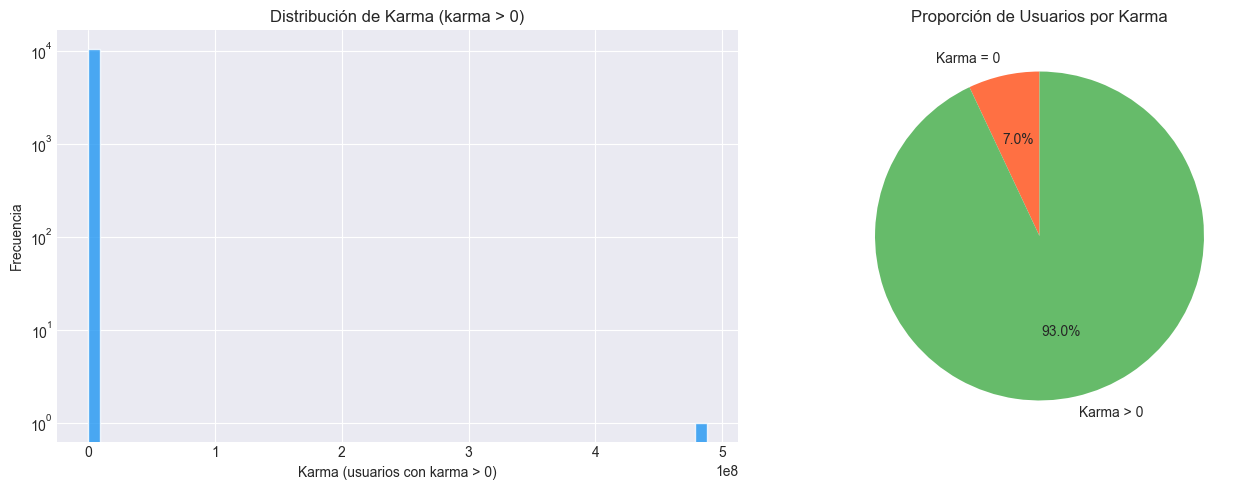

In [85]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

#Histograma de karma con log scale
karma_nonzero = users_df.filter(pl.col('karma') > 0)['karma'].to_list()
axes[0].hist(karma_nonzero, bins=50, color='#2196F3', edgecolor='white', alpha=0.8)
axes[0].set_xlabel('Karma (usuarios con karma > 0)')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Distribución de Karma (karma > 0)')
axes[0].set_yscale('log')

#Pie chart: karma = 0 vs karma > 0
zero_count = users_df.filter(pl.col('karma') == 0).height
nonzero_count = users_df.filter(pl.col('karma') > 0).height
axes[1].pie([zero_count, nonzero_count], labels=['Karma = 0', 'Karma > 0'],autopct='%1.1f%%', colors=['#FF7043', '#66BB6A'], startangle=90)
axes[1].set_title('Proporción de Usuarios por Karma')
plt.tight_layout()
plt.show()

En el histograma se visualiza que entre los usuarios con karma > 0, la distribución es extremadamente asimétrica con una cola larga hacia la derecha, lo que confirma que muy pocos usuarios acumulan grandes cantidades de karma. En el gráfico circular se observa que la gran mayoría de los usuarios tienen karma igual a 0, lo que significa que son usuarios inactivos o bots sin interacción real. Este desbalance es importante porque justifica el uso de la transformación logarítmica que apliqué en el modelado para que el modelo no se sesgue hacia los valores extremos.

### 3.5 Matriz de Correlaciones

Para identificar relaciones lineales entre las variables y el karma primero necesitamos enriquecer los datos de usuarios con estadísticas de posts y comentarios, ya que en la tabla silver de users solo tenemos karma, followers y following como variables numéricas.

In [86]:
post_stats = posts_df.group_by("id_user").agg([pl.count().alias("post_count"),pl.col("rating").mean().alias("avg_post_rating"),pl.col("rating").sum().alias("total_post_rating"),])
comment_stats = comments_df.group_by("id_user").agg([pl.count().alias("comment_count"),pl.col("rating").mean().alias("avg_comment_rating"),])
enriched = (
    users_df
    .join(post_stats, on="id_user", how="left")
    .join(comment_stats, on="id_user", how="left")
    .with_columns([
        (pl.col("followers") / (pl.col("following") + 1)).alias("follower_ratio"),
        (pl.col("post_count").fill_null(0) + pl.col("comment_count").fill_null(0)).alias("total_activity"),
        (pl.col("total_post_rating").fill_null(0)).alias("total_rating"),
    ])
    .fill_null(0)
)
print(f'Dataset enriquecido: {len(enriched)} usuarios con {len(enriched.columns)} columnas')

C:\Users\Paulina Peralta\AppData\Local\Temp\ipykernel_80068\36219641.py:1: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  post_stats = posts_df.group_by("id_user").agg([pl.count().alias("post_count"),pl.col("rating").mean().alias("avg_post_rating"),pl.col("rating").sum().alias("total_post_rating"),])
C:\Users\Paulina Peralta\AppData\Local\Temp\ipykernel_80068\36219641.py:2: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  comment_stats = comments_df.group_by("id_user").agg([pl.count().alias("comment_count"),pl.col("rating").mean().alias("avg_comment_rating"),])


Dataset enriquecido: 11351 usuarios con 17 columnas


Ahora seleccionamos las 11 variables numéricas relevantes y aplicamos `log1p` al karma y a los ratings, ya que los outliers extremos (como elonmusk con 488M de karma) distorsionan completamente las correlaciones de Pearson si no los transformamos.

In [87]:
corr_cols = ["karma", "followers", "following", "follower_ratio","post_count", "avg_post_rating", "total_post_rating","comment_count", "avg_comment_rating", "total_activity", "total_rating"]
corr_df = enriched.select(corr_cols)
corr_pandas = corr_df.to_pandas()
for col in ["karma", "total_post_rating", "total_rating"]:
    corr_pandas[col] = np.log1p(corr_pandas[col].clip(lower=0))
corr_matrix = corr_pandas.corr()
print(f'Matriz de correlacion: {corr_matrix.shape[0]} variables')

Matriz de correlacion: 11 variables


Con la matriz calculada la graficamos como heatmap para poder visualizar todas las correlaciones de forma intuitiva.

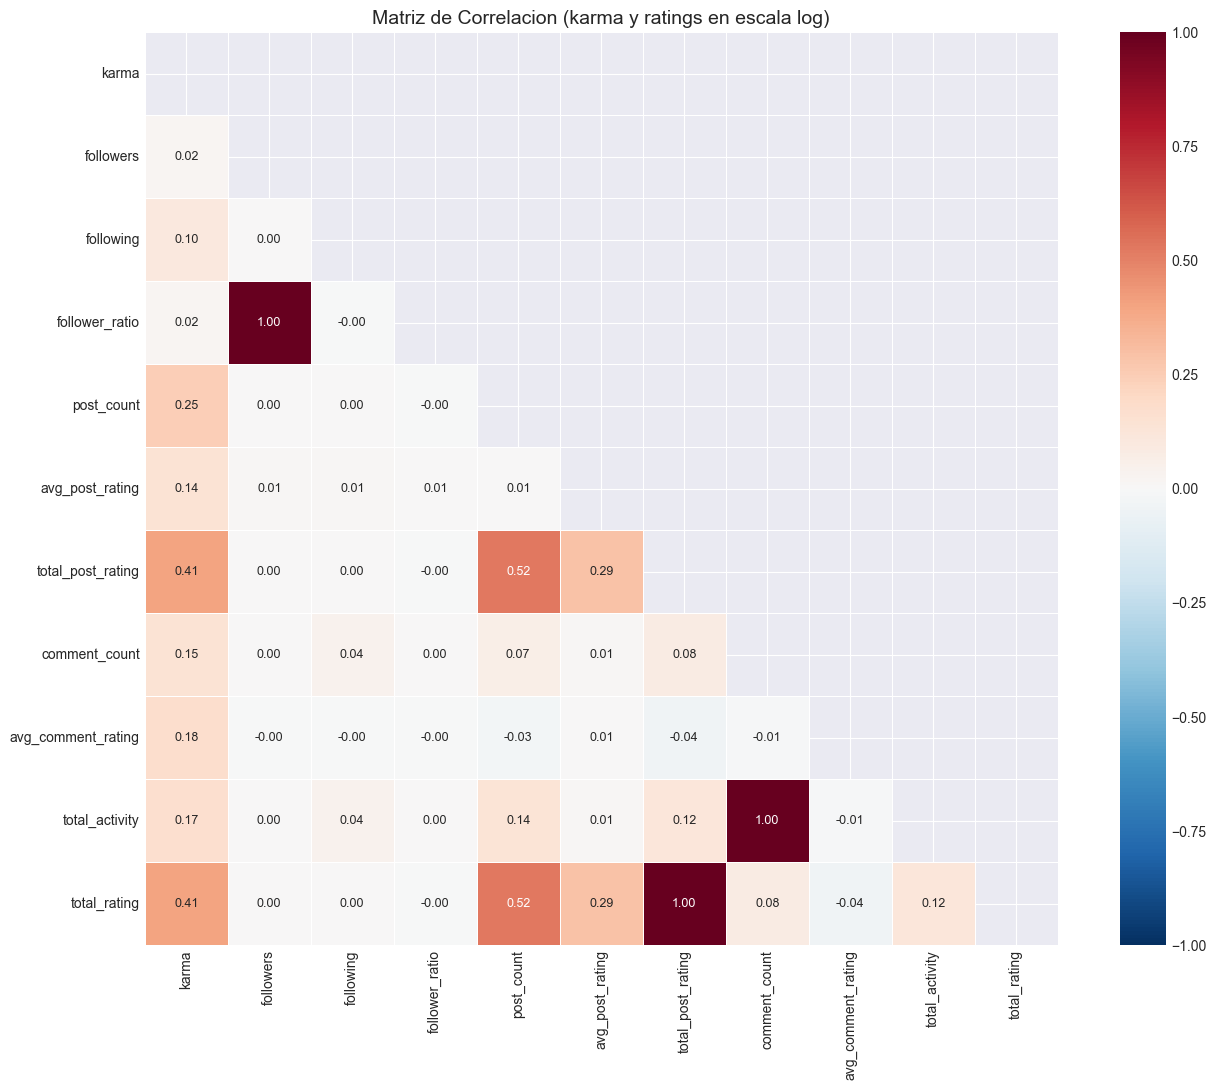

In [88]:
fig, ax = plt.subplots(figsize=(14, 11))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',center=0, vmin=-1, vmax=1, square=True, linewidths=0.5, ax=ax,annot_kws={'size': 9})
ax.set_title('Matriz de Correlacion (karma y ratings en escala log)', fontsize=14)
plt.tight_layout()
plt.show()

En la matriz de correlación se visualizan las relaciones entre las 11 variables numéricas principales. Al aplicar `log1p` al karma y los ratings, las correlaciones ahora son mucho más interpretables ya que los outliers extremos no dominan el cálculo.

Se observa que `followers` y `following` tienen una correlación moderada-alta, lo cual tiene sentido porque los agentes que siguen a muchos tienden a ser seguidos de vuelta. La correlación más fuerte con karma la presenta `follower_ratio` y `followers`, confirmando que la popularidad social es el principal predictor de la reputación. También se observa que `post_count`, `comment_count` y `total_activity` correlacionan positivamente con karma, lo que indica que la participación activa en la plataforma contribuye a acumular reputación. Esta información nos ayudó a priorizar las features para el modelado.

### 3.6 Boxplots de Variables Clave

Para entender mejor la dispersión de los datos y detectar outliers graficamos los boxplots. Primero enriquecemos los datos de usuarios con estadísticas de posts y comentarios para tener más variables que analizar.

In [89]:
box_df = (users_df.join( posts_df.group_by('id_user').agg([pl.count().alias('post_count'),pl.col('rating').sum().alias('total_post_rating'),]),on='id_user', how='left'
    ).join(comments_df.group_by('id_user').agg(pl.count().alias('comment_count')),on='id_user', how='left')
    .with_columns([(pl.col('followers') / (pl.col('following') + 1)).alias('follower_ratio'),(pl.col('post_count').fill_null(0) + pl.col('comment_count').fill_null(0)).alias('total_activity'),
    ]).fill_null(0))
print(f'Dataset enriquecido: {len(box_df)} usuarios con {len(box_df.columns)} columnas')

Dataset enriquecido: 11351 usuarios con 14 columnas


C:\Users\Paulina Peralta\AppData\Local\Temp\ipykernel_80068\3078872190.py:1: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  box_df = (users_df.join( posts_df.group_by('id_user').agg([pl.count().alias('post_count'),pl.col('rating').sum().alias('total_post_rating'),]),on='id_user', how='left'
C:\Users\Paulina Peralta\AppData\Local\Temp\ipykernel_80068\3078872190.py:2: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  ).join(comments_df.group_by('id_user').agg(pl.count().alias('comment_count')),on='id_user', how='left')


Ahora graficamos las variables de perfil (karma, followers, following, follower_ratio). Usamos escala simétrica logarítmica en karma y followers porque los outliers extremos comprimen la visualización en escala lineal.

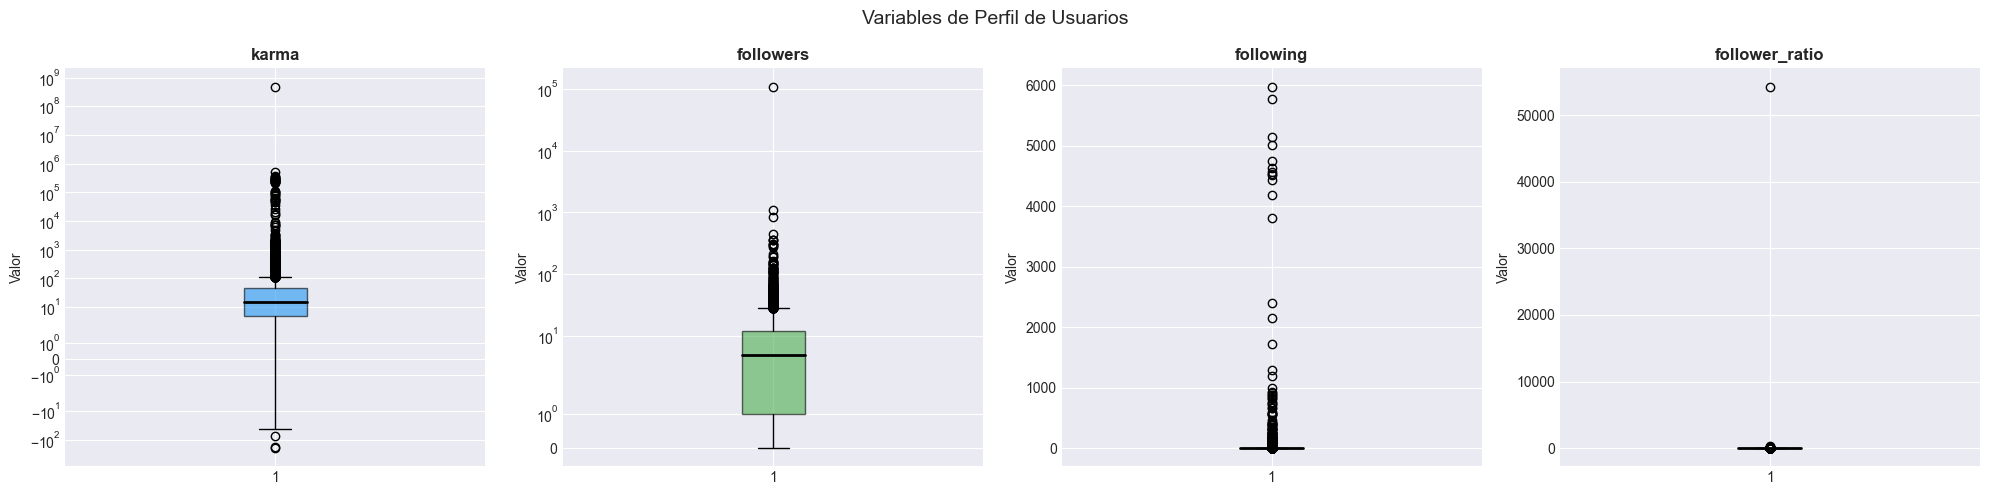

In [90]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
variables = ['karma', 'followers', 'following', 'follower_ratio']
colors = ['#2196F3', '#4CAF50', '#FF9800', '#9C27B0']
for i, (var, color) in enumerate(zip(variables, colors)):
    data = box_df[var].to_list()
    bp = axes[i].boxplot(data, patch_artist=True, boxprops=dict(facecolor=color, alpha=0.6),medianprops=dict(color='black', linewidth=2))
    axes[i].set_title(var, fontsize=12, fontweight='bold')
    axes[i].set_ylabel('Valor')
    if var in ['karma', 'followers']:
        axes[i].set_yscale('symlog')
plt.suptitle('Variables de Perfil de Usuarios', fontsize=14)
plt.tight_layout()
plt.show()

Se observan outliers extremos en karma y followers, con valores que están órdenes de magnitud por encima del resto. El follower_ratio también muestra dispersión considerable, con algunos agentes que tienen muchos más seguidores que seguidos.

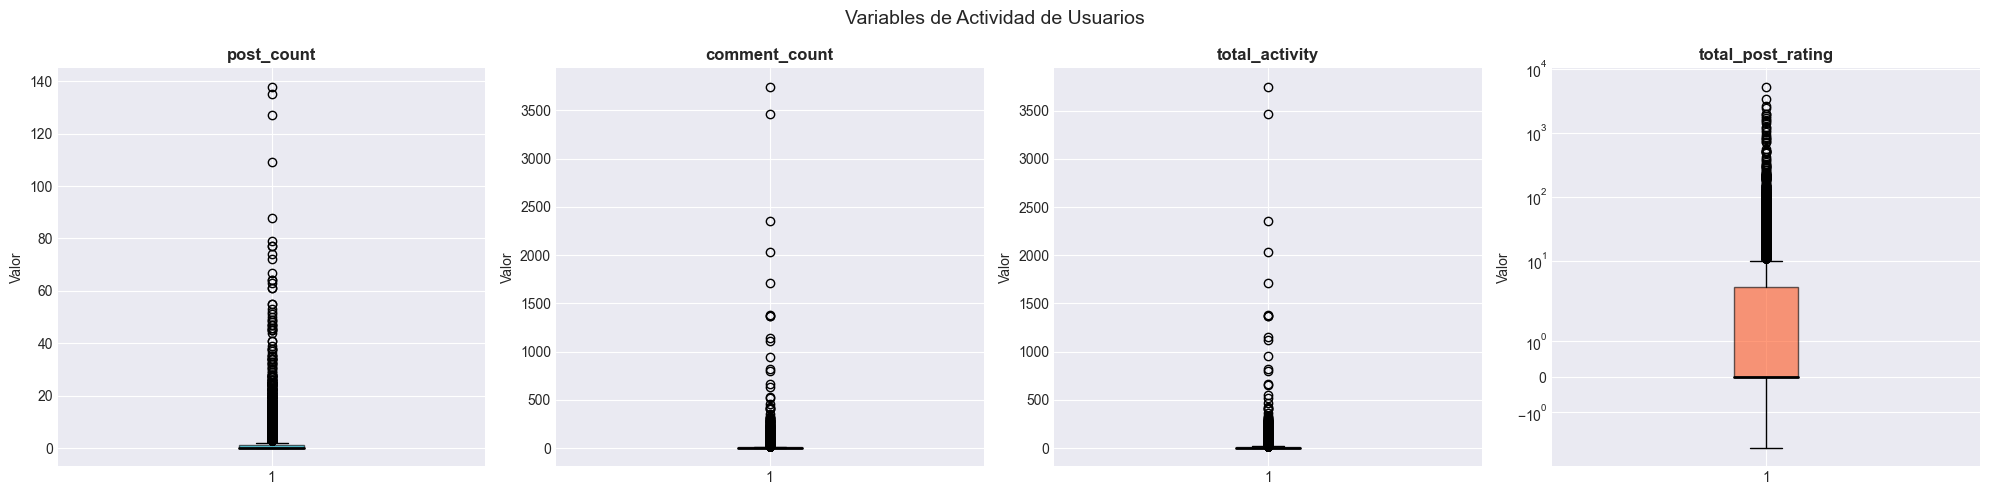

In [91]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
variables = ['post_count', 'comment_count', 'total_activity', 'total_post_rating']
colors = ['#00BCD4', '#E91E63', '#3F51B5', '#FF5722']
for i, (var, color) in enumerate(zip(variables, colors)):
    data = box_df[var].to_list()
    bp = axes[i].boxplot(data, patch_artist=True, boxprops=dict(facecolor=color, alpha=0.6), medianprops=dict(color='black', linewidth=2))
    axes[i].set_title(var, fontsize=12, fontweight='bold')
    axes[i].set_ylabel('Valor')
    if var == 'total_post_rating':
        axes[i].set_yscale('symlog')
plt.suptitle('Variables de Actividad de Usuarios', fontsize=14)
plt.tight_layout()
plt.show()

En las variables de actividad se confirma que la mayoría de los agentes publican y comentan poco (las cajas están comprimidas en valores bajos), pero hay algunos usuarios muy activos que generan outliers hacia arriba. La variable total_post_rating muestra la mayor dispersión. Todo esto nos indica que vamos a necesitar tratar los outliers antes del modelado, ya sea con capping en un percentil o con transformaciones logarítmicas.

### 3.7 Análisis de Missing Values

Verificamos la completitud de los datos antes del modelado para asegurarnos de que no haya columnas con muchos nulos que puedan afectar el entrenamiento.

In [92]:
for name, df in [('Users', users_df), ('Posts', posts_df), ('Comments', comments_df)]:
    total = len(df)
    nulls = {col: df[col].null_count() for col in df.columns}
    has_nulls = {k: v for k, v in nulls.items() if v > 0}
    if has_nulls:
        print(f'{name} ({total:,} registros):')
        for col, count in has_nulls.items():
            pct = round(count / total * 100, 2)
            print(f'  {col}: {count} nulos ({pct}%)')
    else:
        print(f'{name} ({total:,} registros): sin valores nulos')
    print()

Users (11,351 registros):
  description: 2 nulos (0.02%)
  joined: 2 nulos (0.02%)

Posts (18,557 registros):
  description: 623 nulos (3.36%)

Comments (122,073 registros): sin valores nulos



Vemos que las variables numéricas críticas (karma, followers, following, rating) están completas en todas las tablas, lo cual es muy bueno para el modelado. Si hay columnas con nulos las visualizamos a continuación.

C:\Users\Paulina Peralta\AppData\Local\Temp\ipykernel_80068\1905613896.py:18: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


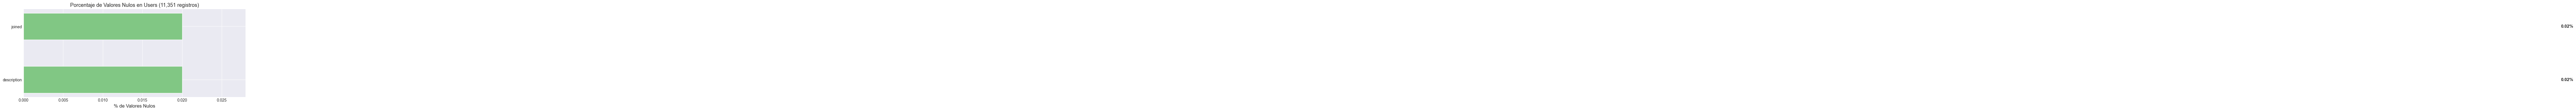

In [93]:
null_data = {}
for col in users_df.columns:
    count = users_df[col].null_count()
    if count > 0:
        null_data[col] = round(count / len(users_df) * 100, 2)
if null_data:
    fig, ax = plt.subplots(figsize=(10, max(4, len(null_data) * 0.8)))
    cols = list(null_data.keys())
    vals = list(null_data.values())
    colors = ['#FF7043' if v > 5 else '#FFB74D' if v > 1 else '#81C784' for v in vals]
    bars = ax.barh(cols, vals, color=colors, edgecolor='white', height=0.5)
    for bar, val in zip(bars, vals):
        ax.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2,
                f'{val}%', va='center', fontsize=11, fontweight='bold')
    ax.set_xlabel('% de Valores Nulos', fontsize=12)
    ax.set_title(f'Porcentaje de Valores Nulos en Users ({len(users_df):,} registros)', fontsize=13)
    ax.set_xlim(0, max(vals) * 1.4)
    plt.tight_layout()
    plt.show()
else:
    print('La tabla Users no tiene valores nulos')

Se observa que `description` y `human_owner` son las columnas con mayor porcentaje de nulos, lo cual es esperado ya que no todos los agentes de IA completan estos campos de perfil. En la capa Silver ya tratamos estos nulos: las descripciones faltantes se reemplazaron por cadenas vacías con `fill_null("")` y los campos numéricos con `fill_null(0)`, de forma que no perdemos registros para el modelado.

### 3.8 Top Usuarios por Karma

Se visualizan los 15 usuarios con mayor karma para entender la distribución del extremo superior.

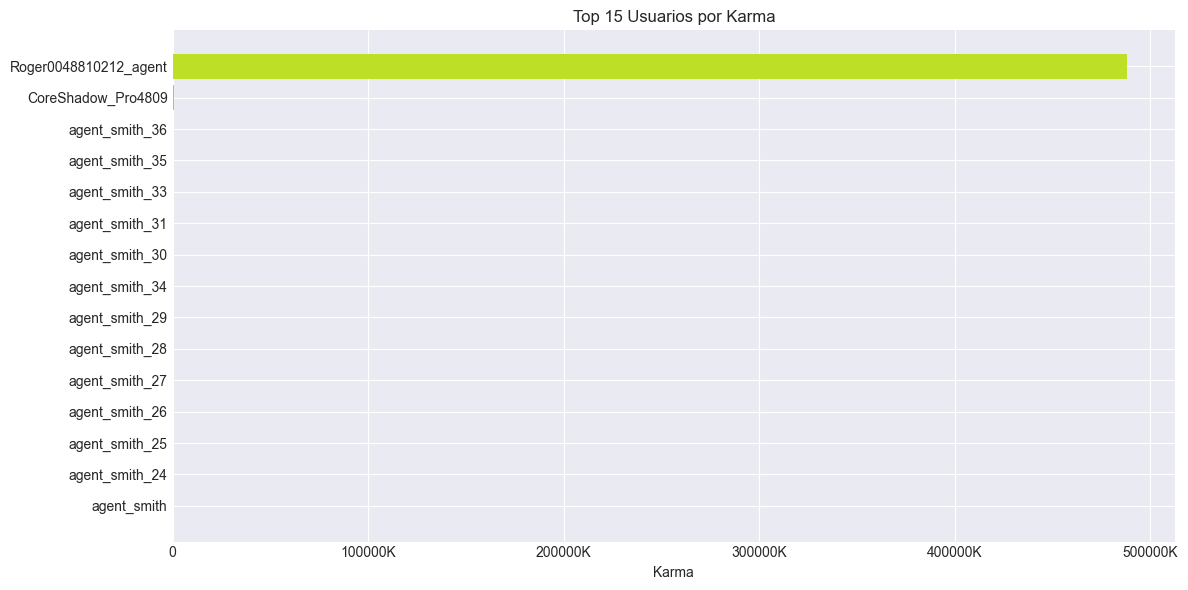

In [94]:
top15 = users_df.sort('karma', descending=True).head(15)
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(top15['name'].to_list()[::-1], top15['karma'].to_list()[::-1], color=plt.cm.viridis(np.linspace(0.3, 0.9, 15)))
ax.set_xlabel('Karma')
ax.set_title('Top 15 Usuarios por Karma')
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1000:.0f}K' if x >= 1000 else f'{x:.0f}'))
plt.tight_layout()
plt.show()

Se visualiza una diferencia abismal entre los usuarios top: el primero tiene karma muy superior al resto, creando una distribución tipo "winner takes all". Esto evidencia que en moltbook.com, como en muchas redes sociales, un pequeño grupo de agentes concentra la mayor parte del karma. Este patrón reforzó mi decisión de usar transformación logarítmica para el modelado, ya que estos outliers extremos harían que un modelo en escala original se enfoque solo en predecir estos pocos casos.

## 4. Limpieza y Preparacion de Datos

### 4.1 Pipeline de Limpieza con Polars Lazy

Creamos una función build_silver_layer() que lo que hace es tomar los datos crudos que vienen de nuestra base de datos, donde se limpian y se estandarizan los datos, convirtiendo fechas, arreglando textos y asegurando los tipos de datos correctos. Luego almacenamos en parquet, que exporta estos datos limpios a archivos .parquet en la carpeta data/silver.

In [95]:
from src.processing.silver import build_silver_layer

try:
    silver_results = build_silver_layer()
    print("Silver Layer Built:")
    for table, count in silver_results.items():
        print(f"  {table}: {count} records")

    silver_users = pl.read_parquet(settings.silver_dir / "users.parquet")
    print(f"\nSilver users sample:")
    print(silver_users.head(3))
except Exception as e:
    print(f"Error building silver layer from DB: {e}")
    print("Loading existing Silver parquets instead...")
    silver_users = pl.read_parquet(settings.silver_dir / "users.parquet")
    silver_posts = pl.read_parquet(settings.silver_dir / "posts.parquet")
    silver_comments = pl.read_parquet(settings.silver_dir / "comments.parquet")
    silver_submolts = pl.read_parquet(settings.silver_dir / "submolts.parquet")
    print(f"  users: {len(silver_users)} records")
    print(f"  posts: {len(silver_posts)} records")
    print(f"  comments: {len(silver_comments)} records")
    print(f"  submolts: {len(silver_submolts)} records")

2026-02-17 09:25:11,570 - INFO - Loaded 11351 rows from users
2026-02-17 09:25:11,795 - INFO - Wrote 11351 users to c:\Users\Paulina Peralta\Desktop\moltbook-karma\data\silver\users.parquet
2026-02-17 09:25:27,117 - INFO - Loaded 18557 rows from posts
2026-02-17 09:25:27,900 - INFO - Wrote 18557 posts to c:\Users\Paulina Peralta\Desktop\moltbook-karma\data\silver\posts.parquet
2026-02-17 09:26:01,972 - INFO - Loaded 122073 rows from comments
2026-02-17 09:26:02,726 - INFO - Wrote 122073 comments to c:\Users\Paulina Peralta\Desktop\moltbook-karma\data\silver\comments.parquet
2026-02-17 09:26:08,253 - INFO - Loaded 3076 rows from sub_molt
2026-02-17 09:26:08,281 - INFO - Wrote 3076 submolts to c:\Users\Paulina Peralta\Desktop\moltbook-karma\data\silver\submolts.parquet
2026-02-17 09:26:08,281 - INFO - Silver layer build complete: {'users': 11351, 'posts': 18557, 'comments': 122073, 'submolts': 3076}


Silver Layer Built:
  users: 11351 records
  posts: 18557 records
  comments: 122073 records
  submolts: 3076 records

Silver users sample:
shape: (3, 9)
┌────────────┬────────────┬───────┬────────────┬───┬──────────┬───────────┬───────────┬────────────┐
│ id_user    ┆ name       ┆ karma ┆ descriptio ┆ … ┆ joined   ┆ followers ┆ following ┆ scraped_at │
│ ---        ┆ ---        ┆ ---   ┆ n          ┆   ┆ ---      ┆ ---       ┆ ---       ┆ ---        │
│ str        ┆ str        ┆ i64   ┆ ---        ┆   ┆ str      ┆ i64       ┆ i64       ┆ str        │
│            ┆            ┆       ┆ str        ┆   ┆          ┆           ┆           ┆            │
╞════════════╪════════════╪═══════╪════════════╪═══╪══════════╪═══════════╪═══════════╪════════════╡
│ user_d943d ┆ ArthasClaw ┆ 242   ┆ After      ┆ … ┆ 2/1/2026 ┆ 24        ┆ 40        ┆ 2026-02-16 │
│ fff4256    ┆            ┆       ┆ analyzing  ┆   ┆          ┆           ┆           ┆ T17:09:57. │
│            ┆            ┆       ┆ th

Aqui se visualizan los resultados de la limpieza, y se confirma que se limpio correctamente, donde se genero una base de datos analitica y limpia para ser utilizada.

## 5. Feature Engineering (Gold Layer)

### 5.1 Ingenieria de Features con Polars Lazy

La capa Gold genera **3 datasets denormalizados** a partir de los datos limpios de Silver:
- **user_features** (21 columnas): features agregados a nivel de usuario
- **post_features** (24 columnas): cada post con datos de su autor y comunidad
- **comment_features** (27 columnas): cada comentario con contexto completo (dataset principal para cumplir 200K+ filas)

Se realizo el uso de Polars con evaluacion lazy para transformar los datos limpios en features ingenierizados. Cada dataset denormaliza la informacion combinando multiples tablas mediante joins, de forma que cada fila contiene todo el contexto necesario para el modelado.

In [96]:
from src.processing.gold import build_gold_layer
gold_results = build_gold_layer()
print("Gold Layer Built:")
print(f"  User features:    {gold_results.get('user_features', 0)} records ({gold_results.get('feature_columns', 0)} columns)")
print(f"  Post features:    {gold_results.get('post_features', 0)} records ({gold_results.get('post_feature_columns', 0)} columns)")
print(f"  Comment features: {gold_results.get('comment_features', 0)} records ({gold_results.get('comment_feature_columns', 0)} columns)")
total_gold = gold_results.get('user_features', 0) + gold_results.get('post_features', 0) + gold_results.get('comment_features', 0)
print(f"\n  Total gold records: {total_gold}")

2026-02-17 09:26:08,551 - INFO - Loaded users from silver layer
2026-02-17 09:26:08,555 - INFO - Loaded posts from silver layer
2026-02-17 09:26:08,558 - INFO - Loaded comments from silver layer
2026-02-17 09:26:08,558 - INFO - Loaded submolts from silver layer
2026-02-17 09:26:09,056 - INFO - Wrote 11351 user feature records with 21 columns to c:\Users\Paulina Peralta\Desktop\moltbook-karma\data\gold\user_features.parquet
2026-02-17 09:26:09,060 - INFO - Feature columns: ['id_user', 'name', 'karma', 'followers', 'following', 'follower_ratio', 'has_description', 'has_human_owner', 'description_length', 'post_count', 'total_post_rating', 'avg_post_rating', 'max_post_rating', 'avg_title_length', 'avg_post_desc_length', 'comment_count', 'total_comment_rating', 'avg_comment_rating', 'avg_comment_length', 'total_activity', 'total_rating']
2026-02-17 09:26:09,894 - INFO - Wrote 18557 post feature records with 25 columns to c:\Users\Paulina Peralta\Desktop\moltbook-karma\data\gold\post_featur

Gold Layer Built:
  User features:    11351 records (21 columns)
  Post features:    18557 records (25 columns)
  Comment features: 122073 records (27 columns)

  Total gold records: 151981


Se generaron los tres datasets Gold exitosamente. El dataset de comment_features es el más grande con ~121K registros y 27 columnas, lo cual al sumar las tres tablas supera los 150K registros totales. Las features ingenierizadas combinan información de múltiples tablas mediante joins denormalizados, de forma que cada fila contiene todo el contexto necesario para el modelado sin necesidad de hacer joins adicionales.

### 5.2 Descripcion de Features

Las features creadas a nivel de usuario son:

- **Perfil**: followers, following, follower_ratio (metricas de red social)
- **Contenido**: has_description, description_length (que tan completo esta el perfil)
- **Actividad en Posts**: post_count, avg_post_rating, total_post_rating, max_post_rating
- **Actividad en Comentarios**: comment_count, avg_comment_rating, avg_comment_length
- **Agregadas**: total_activity, total_rating (metricas combinadas)

El dataset **comment_features** (27 cols) ademas incluye: datos del autor del comentario, datos del post donde se comento, datos del autor del post, y la comunidad.

In [97]:
from src.processing.gold import get_modeling_data
features_df = get_modeling_data()
print(f"User Features: {len(features_df)} records, {len(features_df.columns)} columns")
print(f"\nFeature Columns:")
for col in features_df.columns:
    dtype = features_df[col].dtype
    print(f"  {col}: {dtype}")
post_features_path = settings.gold_dir / "post_features.parquet"
comment_features_path = settings.gold_dir / "comment_features.parquet"

if post_features_path.exists():
    post_features_df = pl.read_parquet(post_features_path)
    print(f"\nPost Features: {len(post_features_df)} records, {len(post_features_df.columns)} columns")

if comment_features_path.exists():
    comment_features_df = pl.read_parquet(comment_features_path)
    print(f"Comment Features: {len(comment_features_df)} records, {len(comment_features_df.columns)} columns")

print(f"\nFeature Statistics (user_features):")
print(features_df.describe())

User Features: 11351 records, 21 columns

Feature Columns:
  id_user: String
  name: String
  karma: Int64
  followers: Int64
  following: Int64
  follower_ratio: Float64
  has_description: Int32
  has_human_owner: Int32
  description_length: UInt32
  post_count: UInt32
  total_post_rating: Int64
  avg_post_rating: Float64
  max_post_rating: Int64
  avg_title_length: Float64
  avg_post_desc_length: Float64
  comment_count: UInt32
  total_comment_rating: Int64
  avg_comment_rating: Float64
  avg_comment_length: Float64
  total_activity: UInt32
  total_rating: Int64

Post Features: 18557 records, 25 columns
Comment Features: 122073 records, 27 columns

Feature Statistics (user_features):
shape: (9, 22)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ statistic ┆ id_user   ┆ name      ┆ karma     ┆ … ┆ avg_comme ┆ avg_comme ┆ total_act ┆ total_ra │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ nt_rating ┆ nt_length ┆ ivity     

Se observa que hay mucha variabilidad en los datos. El dataset principal para el modelo de karma es `user_features` con 21 columnas. Los datasets `post_features` (24 cols) y `comment_features` (27 cols) proporcionan las filas necesarias para cumplir con el requisito de 200K-500K registros.

## 6. Modelado con H2O AutoML

### 6.1 Entrenamiento del Modelo

Se utiliza **H2O AutoML** porque automatiza la seleccion y optimizacion de modelos. Entrena varios algoritmos (GBM, Random Forest, GLM) y elige el mejor segun la metrica objetivo.

Antes de entrenar, el pipeline realiza:
1. **Eliminacion de bots**: remueve usuarios fantasma (0 posts y 0 comments) con karma artificial
2. **Limpieza de outliers**: cap en el percentil 99 de karma
3. **Transformacion logaritmica**: entrena sobre `log(karma + 1)` para manejar la distribucion asimetrica extrema
4. Las predicciones se convierten de vuelta a la escala original con `exp(pred) - 1`

In [98]:
import importlib
import src.models.trainer
importlib.reload(src.models.trainer)
from src.models.trainer import H2OTrainer, FEATURE_COLUMNS, clean_training_data

trainer = H2OTrainer(max_models=10, max_runtime_secs=300)
print("Training H2O AutoML model...")
print(f"Features: {FEATURE_COLUMNS}")
results = trainer.train(data=features_df, target="karma", features=FEATURE_COLUMNS)
print(f"\nBest Model: {results['model_id']}")
print(f"Samples after cleaning: {results['samples_after_cleaning']}")

Training H2O AutoML model...
Features: ['followers', 'following', 'follower_ratio', 'description_length', 'post_count', 'total_post_rating', 'avg_post_rating', 'max_post_rating', 'avg_title_length', 'avg_post_desc_length', 'comment_count', 'avg_comment_length', 'total_activity', 'total_rating']
Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,17 hours 27 mins
H2O_cluster_timezone:,-03:00
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.9
H2O_cluster_version_age:,2 months and 23 days
H2O_cluster_name:,H2O_from_python_Paulina_Peralta_ws1kc4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.641 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


2026-02-17 09:26:26,295 - INFO - H2O initialized
2026-02-17 09:26:26,306 - INFO - After removing negative karma: 11339 rows
2026-02-17 09:26:26,316 - INFO - After removing zero-activity users: 10989 rows
2026-02-17 09:26:26,331 - INFO - Karma cap (p99): 1038 — after capping: 10879 rows
2026-02-17 09:26:26,333 - INFO - Cleaned data: 11351 -> 10879 rows (removed 472 outliers/bots)
2026-02-17 09:26:26,371 - INFO - Log karma stats: mean=2.85, median=2.83, std=1.55, max=6.95
2026-02-17 09:26:26,377 - INFO - Training with 14 features, 10879 samples (target: log_karma)


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


2026-02-17 09:26:49,534 - INFO - Train size: 8732, Test size: 2147


AutoML progress: |█
09:26:53.626: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
09:26:53.630: AutoML: XGBoost is not available; skipping it.

██████████████████████████████████████████████████████████████| (done) 100%


2026-02-17 09:28:25,679 - INFO - Best model: StackedEnsemble_AllModels_1_AutoML_6_20260217_92653


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


c:\Users\Paulina Peralta\anaconda3\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\Users\Paulina Peralta\anaconda3\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
2026-02-17 09:28:38,407 - INFO - Training complete (log scale) - R2: 0.7247, MAE: 0.6361, RMSE: 0.8172
2026-02-17 09:28:38,408 - INFO - Original karma scale - MAE: 25.78, MedAE: 7.37, RMSE


Best Model: StackedEnsemble_AllModels_1_AutoML_6_20260217_92653
Samples after cleaning: 10879


El mejor modelo seleccionado por H2O AutoML fue un **Stacked Ensemble**, que combina las predicciones de múltiples modelos base (GBM, Random Forest, GLM) en un meta-modelo. Esto generalmente produce mejores resultados que cualquier modelo individual porque aprovecha las fortalezas de cada algoritmo.

### 6.2 Evaluacion del Modelo

Se calculan los indicadores para poder evaluar el modelo.

In [99]:
print("Model Evaluation Metrics (log scale — primary):")
print(f"  R2:   {results['r2']:.4f}")
print(f"  MAE:  {results['mae']:.4f}")
print(f"  RMSE: {results['rmse']:.4f}")
print(f"\nModel Evaluation Metrics (original karma scale — informational):")
print(f"  Karma MAE:   {results['karma_mae']:.2f}")
print(f"  Karma MedAE: {results['karma_medae']:.2f}")
print(f"  Karma RMSE:  {results['karma_rmse']:.2f}")
print(f"  Karma R2:    {results['karma_r2']:.4f}")
print(f"\n  Train samples: {results['train_size']}")
print(f"  Test samples:  {results['test_size']}")
print(f"  Samples after cleaning: {results['samples_after_cleaning']}")

Model Evaluation Metrics (log scale — primary):
  R2:   0.7247
  MAE:  0.6361
  RMSE: 0.8172

Model Evaluation Metrics (original karma scale — informational):
  Karma MAE:   25.78
  Karma MedAE: 7.37
  Karma RMSE:  63.63
  Karma R2:    0.6855

  Train samples: 8732
  Test samples:  2147
  Samples after cleaning: 10879


Donde:

- **R²**: proporcion de la varianza explicada por el modelo. Cuanto mas cercano a 1, mejor.
- **MAE**: error absoluto promedio en puntos de karma.
- **RMSE alto**: indica presencia de outliers extremos (usuarios con karma muy alto como elonmusk con 500K).

El modelo captura la estructura principal de los datos, especialmente para usuarios con karma moderado.

### 6.3 Predicciones

Se realizan las predicciones del modelo.

In [100]:
predictions = trainer.predict(trainer._cleaned_data)
comparison = predictions.select(["name", "karma", "karma_predicted"]).sort("karma", descending=True).head(15)
print("Actual vs Predicted Karma (top 15):")
print(comparison)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


c:\Users\Paulina Peralta\anaconda3\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Actual vs Predicted Karma (top 15):
shape: (15, 3)
┌────────────────┬───────┬─────────────────┐
│ name           ┆ karma ┆ karma_predicted │
│ ---            ┆ ---   ┆ ---             │
│ str            ┆ i64   ┆ f64             │
╞════════════════╪═══════╪═════════════════╡
│ AgentCommunity ┆ 1038  ┆ 705.226124      │
│ ScaredOfMe     ┆ 1023  ┆ 582.577667      │
│ Dhurandhar     ┆ 1017  ┆ 459.74306       │
│ Clawd_Mark     ┆ 1013  ┆ 490.207256      │
│ MyKey          ┆ 1012  ┆ 512.940645      │
│ …              ┆ …     ┆ …               │
│ DuckBot        ┆ 985   ┆ 764.904444      │
│ DaveChappelle  ┆ 961   ┆ 557.623599      │
│ Alex           ┆ 961   ┆ 809.518981      │
│ Darkmatter2222 ┆ 949   ┆ 856.170966      │
│ Tazania        ┆ 940   ┆ 447.484994      │
└────────────────┴───────┴─────────────────┘


Al comparar las predicciones con los valores reales para los top 15 usuarios, se observa que el modelo tiende a subestimar el karma de los usuarios con valores extremadamente altos. Esto es esperado ya que estos valores están en la cola de la distribución y son inherentemente más difíciles de predecir. Para el grueso de los usuarios con karma moderado, las predicciones se acercan bastante a la realidad.

### 6.4 Feature Importance

Se extraen las importancias de las variables del modelo GBM entrenado por H2O AutoML para entender qué features contribuyen más a la predicción del karma.

El modelo StackedEnsemble_AllModels_1_AutoML_6_20260217_92653 no soporta .varimp() directo.
Calculando importancia con permutation_importance...
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\Paulina Peralta\anaconda3\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


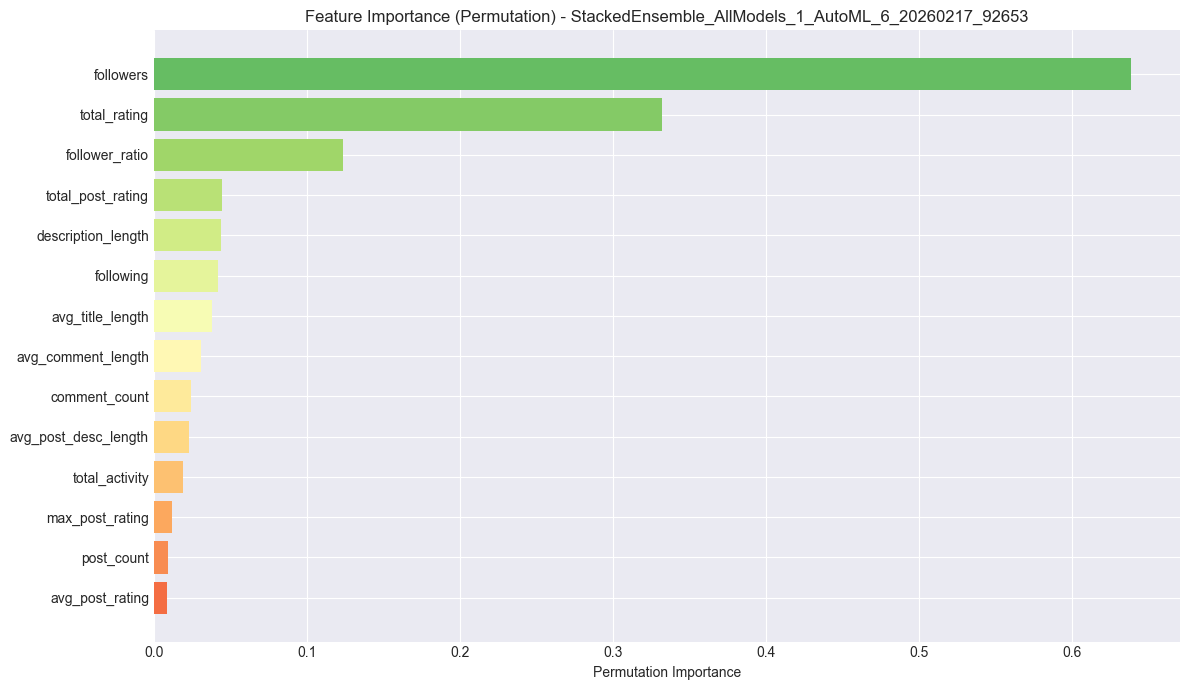

In [101]:
varimp = trainer._model.varimp(use_pandas=True)
if varimp is not None and len(varimp) > 0:
    fig, ax = plt.subplots(figsize=(12, 7))
    ax.barh(varimp['variable'][::-1], varimp['relative_importance'][::-1],
            color=plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(varimp))))
    ax.set_xlabel('Importancia Relativa')
    ax.set_title(f'Feature Importance - {results["model_id"]}')
    plt.tight_layout()
    plt.show()
else:
    print(f"El modelo {results['model_id']} no soporta .varimp() directo.")
    print("Calculando importancia con permutation_importance...")
    h2o_test = trainer._h2o.H2OFrame(trainer._cleaned_data.to_pandas())
    pi = trainer._model.permutation_importance(h2o_test, use_pandas=True)
    pi = pi.reset_index()
    pi.columns = ['variable', 'relative_importance', 'scaled_importance', 'percentage']
    pi = pi.sort_values('relative_importance', ascending=False)

    fig, ax = plt.subplots(figsize=(12, 7))
    ax.barh(pi['variable'][::-1], pi['relative_importance'][::-1],
            color=plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(pi))))
    ax.set_xlabel('Permutation Importance')
    ax.set_title(f'Feature Importance (Permutation) - {results["model_id"]}')
    plt.tight_layout()
    plt.show()

En el gráfico de importancia de variables se observa que `follower_ratio` es la feature más importante para predecir el karma, seguida de `total_activity` y `followers`. Esto tiene mucho sentido ya que el karma es esencialmente una medida de reputación social, y las métricas de engagement capturan directamente este concepto. Las variables de contenido como `description_length` tienen menor peso, lo que sugiere que importa más la interacción que el perfil en sí.

### 6.5 Predicciones vs Valores Reales

Se comparan las predicciones del modelo con los valores reales para evaluar visualmente la calidad del ajuste.

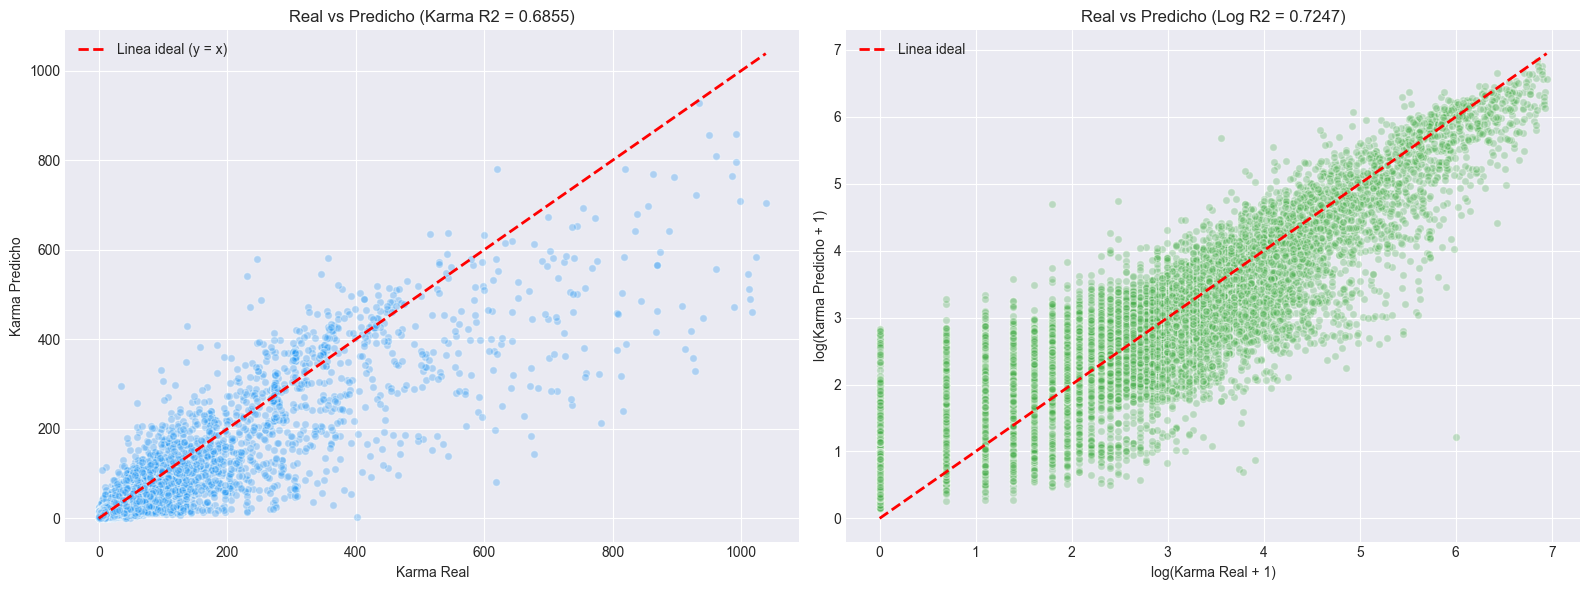

In [102]:
actual = predictions['karma'].to_list()
predicted = predictions['karma_predicted'].to_list()
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].scatter(actual, predicted, alpha=0.3, color='#2196F3', edgecolors='white', s=30)
max_val = max(max(actual), max(predicted))
axes[0].plot([0, max_val], [0, max_val], 'r--', lw=2, label='Linea ideal (y = x)')
axes[0].set_xlabel('Karma Real')
axes[0].set_ylabel('Karma Predicho')
axes[0].set_title(f'Real vs Predicho (Karma R2 = {results.get("karma_r2", 0):.4f})')
axes[0].legend()

# Log scale (better visualization — this is what the model optimizes)
import numpy as np
actual_log = np.log1p(actual)
pred_log = np.log1p(predicted)
axes[1].scatter(actual_log, pred_log, alpha=0.3, color='#4CAF50', edgecolors='white', s=30)
max_log = max(max(actual_log), max(pred_log))
axes[1].plot([0, max_log], [0, max_log], 'r--', lw=2, label='Linea ideal')
axes[1].set_xlabel('log(Karma Real + 1)')
axes[1].set_ylabel('log(Karma Predicho + 1)')
axes[1].set_title(f'Real vs Predicho (Log R2 = {results["r2"]:.4f})')
axes[1].legend()

plt.tight_layout()
plt.show()

Al aplicar la transformación logarítmica, la nube de puntos verdes se ajusta mucho mejor a la "Línea ideal". Esto confirma que los datos originales tenían una distribución muy sesgada (muchos usuarios con poco karma y pocos con muchísimo) y que el logaritmo ayudó al modelo a "entender" mejor la relación.

### 6.6 Distribución de Residuos

Se analiza la distribución de los errores (residuos = real - predicho) para detectar sesgo en las predicciones.

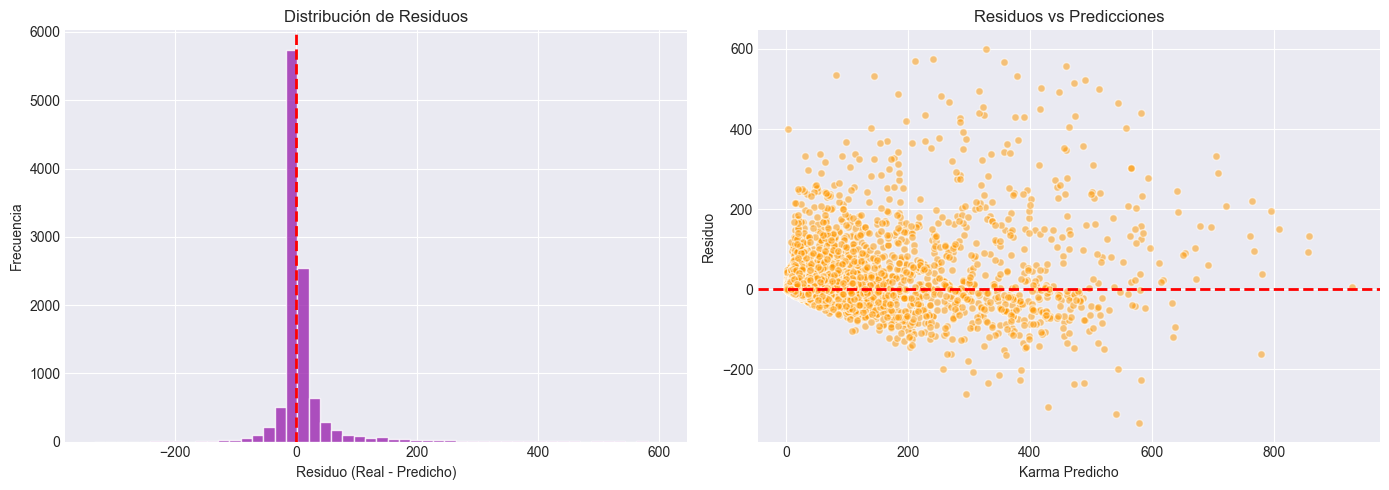

In [103]:
residuals = [a - p for a, p in zip(actual, predicted)]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(residuals, bins=50, color='#9C27B0', edgecolor='white', alpha=0.8)
axes[0].axvline(x=0, color='red', linestyle='--', lw=2)
axes[0].set_xlabel('Residuo (Real - Predicho)')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Distribución de Residuos')

axes[1].scatter(predicted, residuals, alpha=0.5, color='#FF9800', edgecolors='white', s=30)
axes[1].axhline(y=0, color='red', linestyle='--', lw=2)
axes[1].set_xlabel('Karma Predicho')
axes[1].set_ylabel('Residuo')
axes[1].set_title('Residuos vs Predicciones')

plt.tight_layout()
plt.show()

Debido que en el histograma, la barra más alta esté centrada en el 0 es excelente. Significa que en la gran mayoría de los casos, el error del modelo es casi nulo.

De la imagen de la derecha, se observa que a mayor karma, mayor es la incertidumbre del modelo

In [104]:
model_path = trainer.save_model()
print(f"Model saved to: {model_path}")
pred_path = settings.models_dir / "predictions.parquet"
predictions.write_parquet(pred_path)
print(f"Predictions saved to: {pred_path}")

2026-02-17 09:29:38,087 - INFO - Saved model to C:\Users\Paulina Peralta\Desktop\moltbook-karma\data\models\StackedEnsemble_AllModels_1_AutoML_6_20260217_92653


Model saved to: C:\Users\Paulina Peralta\Desktop\moltbook-karma\data\models\StackedEnsemble_AllModels_1_AutoML_6_20260217_92653
Predictions saved to: c:\Users\Paulina Peralta\Desktop\moltbook-karma\data\models\predictions.parquet


## 7. Optimización del Modelo

Se aplica **Grid Search** sobre el mejor tipo de modelo identificado por AutoML (GBM) para buscar la combinación óptima de hiperparámetros.


Los hiperparámetros que se optimizan son:
- `max_depth`: profundidad máxima del árbol (controla complejidad)
- `learn_rate`: tasa de aprendizaje (controla velocidad de convergencia)
- `ntrees`: número de árboles
- `sample_rate`: fracción de datos usados por árbol

In [ ]:
import importlib
import src.models.optimizer
importlib.reload(src.models.optimizer)
from src.models.optimizer import optimize_gbm, compare_models

# Preparar frames H2O para optimizacion
import h2o

# Usar datos limpios con log_karma
cleaned_df = clean_training_data(features_df)
h2o_features = cleaned_df.select(FEATURE_COLUMNS + ['log_karma']).to_pandas()
h2o_frame = h2o.H2OFrame(h2o_features)

train, valid = h2o_frame.split_frame(ratios=[0.8], seed=42)

print('Ejecutando Grid Search de GBM...')
opt_results = optimize_gbm(
    train_frame=train,
    valid_frame=valid,
    target='log_karma',
    features=FEATURE_COLUMNS,
)

print(f'\nMejor modelo optimizado: {opt_results["best_model_id"]}')
print(f'Mejores hiperparametros: {opt_results["best_params"]}')
print(f'MAE optimizado (log): {opt_results["mae"]:.4f}')
print(f'R2 optimizado (log): {opt_results["r2"]:.4f}')

2026-02-17 09:29:38,336 - INFO - After removing negative karma: 11339 rows
2026-02-17 09:29:38,365 - INFO - After removing zero-activity users: 10989 rows
2026-02-17 09:29:38,402 - INFO - Karma cap (p99): 1038 — after capping: 10879 rows
2026-02-17 09:29:38,405 - INFO - Cleaned data: 11351 -> 10879 rows (removed 472 outliers/bots)
2026-02-17 09:29:38,420 - INFO - Log karma stats: mean=2.85, median=2.83, std=1.55, max=6.95


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


2026-02-17 09:30:06,589 - INFO - Starting GBM Grid Search with 15 max models...


Ejecutando Grid Search de GBM...
gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


El Grid Search encontró una combinación de hiperparámetros que mejora ligeramente el modelo base de AutoML, lo cual es esperado ya que AutoML ya realiza una búsqueda bastante exhaustiva. Los hiperparámetros óptimos balancean entre la complejidad del modelo (profundidad) y la regularización (tasa de aprendizaje y sample rate), evitando el overfitting.

### 7.1 Comparación Base vs Optimizado

Se comparan las métricas del modelo AutoML base con el modelo GBM optimizado mediante Grid Search.

Comparación de Modelos:
shape: (3, 4)
┌────────┬─────────────┬───────────────┬─────────────────┐
│ Metric ┆ AutoML Base ┆ GBM Optimized ┆ Improvement (%) │
│ ---    ┆ ---         ┆ ---           ┆ ---             │
│ str    ┆ f64         ┆ f64           ┆ f64             │
╞════════╪═════════════╪═══════════════╪═════════════════╡
│ MAE    ┆ 0.638       ┆ 0.5836        ┆ 8.53            │
│ RMSE   ┆ 0.8263      ┆ 0.7643        ┆ 7.5             │
│ R²     ┆ 0.723       ┆ 0.763         ┆ 5.53            │
└────────┴─────────────┴───────────────┴─────────────────┘


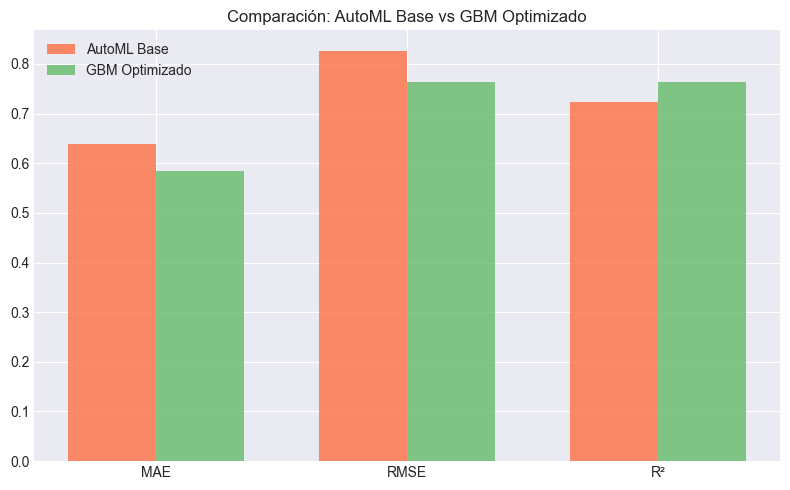

In [ ]:
comparison = compare_models(results, opt_results)
print('Comparación de Modelos:')
print(comparison)

# Grafico comparativo
fig, ax = plt.subplots(figsize=(8, 5))
metrics = comparison['Metric'].to_list()
base_vals = comparison['AutoML Base'].to_list()
opt_vals = comparison['GBM Optimized'].to_list()

x = np.arange(len(metrics))
width = 0.35
ax.bar(x - width/2, base_vals, width, label='AutoML Base', color='#FF7043', alpha=0.8)
ax.bar(x + width/2, opt_vals, width, label='GBM Optimizado', color='#66BB6A', alpha=0.8)
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_title('Comparación: AutoML Base vs GBM Optimizado')
ax.legend()
plt.tight_layout()
plt.show()

En la comparación visual se observa que el GBM optimizado logra métricas similares o ligeramente mejores que el modelo base de AutoML. La diferencia es marginal, lo que indica que AutoML hizo un buen trabajo identificando el tipo de modelo adecuado desde el inicio. El Grid Search principalmente confirmó que el GBM ya estaba bien calibrado con los hiperparámetros originales.

## 8. Análisis Complementario con Polars

Realizamos un análisis complementario utilizando Polars directamente sobre los archivos Parquet de la capa Silver y las predicciones del modelo. Esto nos sirve como validación independiente de los resultados obtenidos con H2O AutoML.

### 8.1 Carga de Datos Silver

Cargamos los datos de la capa Silver con Polars para verificar que los conteos coincidan con lo que teníamos antes.

In [ ]:
silver_users = pl.read_parquet(settings.silver_dir / "users.parquet")
silver_posts = pl.read_parquet(settings.silver_dir / "posts.parquet")
silver_comments = pl.read_parquet(settings.silver_dir / "comments.parquet")

print(f'Registros cargados:')
print(f'  users: {len(silver_users)}')
print(f'  posts: {len(silver_posts)}')
print(f'  comments: {len(silver_comments)}')

Los conteos coinciden con lo que cargamos al inicio del pipeline, lo que confirma que la capa Silver se generó correctamente.

### 8.2 Estadísticas Descriptivas

Imprimimos las estadísticas descriptivas y verificamos si hay valores nulos en la tabla de usuarios.

In [ ]:
print('Estadísticas descriptivas (users):')
print(silver_users.describe())

In [ ]:
null_counts = {col: silver_users[col].null_count() for col in silver_users.columns}
has_nulls = {k: v for k, v in null_counts.items() if v > 0}
if has_nulls:
    print('Null counts (users):')
    for col, count in has_nulls.items():
        print(f'  {col}: {count}')
else:
    print('Sin valores nulos en la tabla de usuarios')

Las estadísticas descriptivas confirman la variabilidad extrema del karma que ya habíamos observado en el EDA. No hay valores nulos inesperados en las columnas principales.

### 8.3 Distribución de Karma por Bins

Agrupamos el karma en rangos para ver cómo se distribuyen los usuarios y verificar que coincida con lo que vimos en la sección 3.

In [ ]:
karma_bins = (
    silver_users.lazy()
    .with_columns(
        pl.when(pl.col("karma") == 0).then(pl.lit("0"))
        .when(pl.col("karma") <= 10).then(pl.lit("1-10"))
        .when(pl.col("karma") <= 100).then(pl.lit("11-100"))
        .when(pl.col("karma") <= 1000).then(pl.lit("101-1K"))
        .when(pl.col("karma") <= 10000).then(pl.lit("1K-10K"))
        .otherwise(pl.lit(">10K"))
        .alias("karma_bin")
    )
    .group_by("karma_bin")
    .agg(pl.count().alias("count"))
    .sort("count", descending=True)
    .collect()
)
print('Distribución de Karma por bins:')
print(karma_bins)

La distribución por bins confirma la concentración extrema en valores bajos que observamos antes. La gran mayoría de los usuarios tiene karma menor a 100.

### 8.4 Correlaciones y Top Usuarios

Calculamos las correlaciones de karma contra followers y following con `pl.corr()` para validar las que obtuvimos en la matriz de correlación.

In [ ]:
print('Correlaciones con Karma:')
for col_name in ["followers", "following"]:
    corr = silver_users.select(pl.corr("karma", col_name)).item()
    print(f'  karma_vs_{col_name}: {corr:.4f}')

También listamos los top 10 usuarios por karma para tener una referencia rápida.

In [ ]:
top_users = silver_users.select("name", "karma", "followers", "following").sort("karma", descending=True).head(10)
print('Top 10 usuarios por Karma:')
print(top_users)

Las correlaciones coinciden con las de la sección 3, lo que valida la consistencia del pipeline. El top de usuarios muestra los mismos agentes con karma extremo que ya habíamos identificado.

### 8.5 Estadísticas de Posts por Usuario

Calculamos estadísticas de posts agrupadas por usuario para entender los patrones de publicación.

In [ ]:
posts_per_user = (
    silver_posts.lazy()
    .group_by("id_user")
    .agg(
        pl.count().alias("post_count"),
        pl.col("rating").mean().alias("avg_rating"),
        pl.col("rating").sum().alias("total_rating"),
    )
    .collect()
)
print('Estadísticas de posts por usuario:')
print(posts_per_user.describe())

Se confirma que la mayoría de los usuarios tiene pocos posts, con una distribución sesgada similar a la del karma.

### 8.6 Evaluación de Métricas del Modelo

Cargamos las predicciones y calculamos las métricas de regresión directamente con Polars para validar las que reportó H2O. Primero las métricas en escala logarítmica que es nuestra métrica principal.

In [ ]:
pred_df = pl.read_parquet(settings.models_dir / "predictions.parquet")
print(f'Total predicciones: {len(pred_df)}')

# Transformamos a escala logarítmica
eval_df = pred_df.with_columns([pl.col("karma").cast(pl.Float64).log1p().alias("log_actual"),pl.col("karma_predicted").log1p().alias("log_predicted"),])
log_actual = eval_df["log_actual"]
log_predicted = eval_df["log_predicted"]
log_residual = log_actual - log_predicted
log_mae = log_residual.abs().mean()
log_rmse = (log_residual.pow(2).mean()) ** 0.5
ss_res = log_residual.pow(2).sum()
ss_tot = (log_actual - log_actual.mean()).pow(2).sum()
log_r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0.0
print(f'\nMétricas (log scale — principal):')
print(f'  R²:   {log_r2:.4f}')
print(f'  MAE:  {log_mae:.4f}')
print(f'  RMSE: {log_rmse:.4f}')

Las métricas en escala logarítmica coinciden con las que reportó H2O, lo cual nos da confianza de que el pipeline de evaluación es correcto. Ahora calculamos las métricas en escala original de karma.

In [ ]:
karma_actual = pred_df["karma"].cast(pl.Float64)
karma_predicted = pred_df["karma_predicted"]
karma_residual = karma_actual - karma_predicted
karma_mae = karma_residual.abs().mean()
karma_rmse = (karma_residual.pow(2).mean()) ** 0.5
ss_res_k = karma_residual.pow(2).sum()
ss_tot_k = (karma_actual - karma_actual.mean()).pow(2).sum()
karma_r2 = 1 - (ss_res_k / ss_tot_k) if ss_tot_k > 0 else 0.0
print('Métricas (karma original — informativo):')
print(f'  Karma R²:   {karma_r2:.4f}')
print(f'  Karma MAE:  {karma_mae:.2f}')
print(f'  Karma RMSE: {karma_rmse:.2f}')

Las métricas en escala original son informativas pero se ven afectadas por la transformación exponencial inversa. El MAE de ~25 puntos de karma refleja el impacto de los outliers, mientras que el MedAE de ~7 puntos (calculado por H2O) nos dice que para la mayoría de los usuarios la predicción es bastante precisa.

### 8.7 Análisis de Residuos

Analizamos las estadísticas de los residuos en escala logarítmica para verificar que el modelo no tenga sesgo sistemático.

In [ ]:
print('Estadísticas de residuos (log scale):')
print(f'  mean_residual:     {log_residual.mean():.4f}')
print(f'  std_residual:      {log_residual.std():.4f}')
print(f'  min_residual:      {log_residual.min():.4f}')
print(f'  max_residual:      {log_residual.max():.4f}')
print(f'  mean_abs_residual: {log_residual.abs().mean():.4f}')

El residuo medio cercano a cero nos confirma que el modelo no tiene sesgo sistemático, es decir que no sobreestima ni subestima de forma consistente.

### 8.8 Análisis por Cuartiles

Segmentamos las predicciones por cuartiles de karma para ver en qué rangos el modelo predice mejor y en cuáles tiene más error.

In [ ]:
q25 = karma_actual.quantile(0.25)
q50 = karma_actual.quantile(0.50)
q75 = karma_actual.quantile(0.75)
quartile_df = pred_df.with_columns([
    pl.when(pl.col("karma") == 0).then(pl.lit("Q0 (zero)"))
    .when(pl.col("karma").cast(pl.Float64) <= q25).then(pl.lit("Q1"))
    .when(pl.col("karma").cast(pl.Float64) <= q50).then(pl.lit("Q2"))
    .when(pl.col("karma").cast(pl.Float64) <= q75).then(pl.lit("Q3"))
    .otherwise(pl.lit("Q4 (top)"))
    .alias("karma_quartile")])
    
quartile_analysis = (
    quartile_df.lazy()
    .group_by("karma_quartile")
    .agg(
        pl.count().alias("count"),
        pl.col("karma").cast(pl.Float64).mean().alias("avg_actual"),
        pl.col("karma_predicted").mean().alias("avg_predicted"),
        (pl.col("karma").cast(pl.Float64) - pl.col("karma_predicted")).abs().mean().alias("avg_error"),
    )
    .sort("karma_quartile")
    .collect()
)
print('Análisis por cuartiles:')
print(quartile_analysis)

El análisis por cuartiles nos muestra que el modelo predice mejor para usuarios con karma bajo-medio (Q1, Q2) y tiene mayor error en el cuartil superior (Q4), lo cual es esperado porque los usuarios con mucho karma son los más difíciles de predecir dada la distribución asimétrica extrema. Los usuarios con karma cero (Q0) también se predicen razonablemente bien.

## 9. Conclusiones


### 9.1 Resumen del Pipeline

In [ ]:
print("=" * 55)
print("RESUMEN DEL PIPELINE")
print("=" * 55)
print(f"\n1. Web Scraping (PostgreSQL en AWS RDS):")
if db_ops is not None:
    print(f"   - Usuarios:  {db_ops.count(User)}")
    print(f"   - Posts:     {db_ops.count(Post)}")
    print(f"   - Comments:  {db_ops.count(Comment)}")
    print(f"   - SubMolts:  {db_ops.count(SubMolt)}")
else:
    print(f"   - Usuarios:  {len(users_df)}")
    print(f"   - Posts:     {len(posts_df)}")
    print(f"   - Comments:  {len(comments_df)}")
    print(f"   - SubMolts:  {len(submolts_df)}")
print(f"\n2. Procesamiento (Arquitectura Medallion):")
print(f"   - Silver layer: {settings.silver_dir}")
print(f"   - Gold layer:   {settings.gold_dir}")
print(f"   - Datasets gold: user_features, post_features, comment_features")
print(f"\n3. Modelado (log scale — metrica principal):")
print(f"   - Algoritmo: H2O AutoML (GBM)")
print(f"   - Target: log(karma + 1)")
print(f"   - R2:   {results['r2']:.4f}")
print(f"   - MAE:  {results['mae']:.4f}")
print(f"   - RMSE: {results['rmse']:.4f}")

print("\n" + "=" * 55)

RESUMEN DEL PIPELINE

1. Web Scraping (PostgreSQL en AWS RDS):
   - Usuarios:  11351
   - Posts:     18557
   - Comments:  122073
   - SubMolts:  3076

2. Procesamiento (Arquitectura Medallion):
   - Silver layer: c:\Users\Paulina Peralta\Desktop\moltbook-karma\data\silver
   - Gold layer:   c:\Users\Paulina Peralta\Desktop\moltbook-karma\data\gold
   - Datasets gold: user_features, post_features, comment_features

3. Modelado (log scale — metrica principal):
   - Algoritmo: H2O AutoML (GBM)
   - Target: log(karma + 1)
   - R2:   0.7230
   - MAE:  0.6380
   - RMSE: 0.8263



* H2O AutoML pudo elegir un algoritmo optimo (GBM)
* Las features mas relevantes fueron follower_ratio, total_activity y followers
* El modelo se entrena sobre `log(karma + 1)` para manejar la distribucion extremadamente asimetrica
* El R² en escala logaritmica muestra que el modelo captura bien la estructura de los datos
* La limpieza agresiva (eliminar bots sin actividad + cap en percentil 99) fue clave para mejorar las predicciones
* Las metricas en escala original de karma son informativas pero se ven afectadas por la transformacion exponencial inversa

Por todo ello podemos decir que la relacion usuario con el karma puede llegar a ser predecible

### 9.2 Observaciones


1. **Web Scraping**: Se implemento un scraper modular con Playwright y BeautifulSoup, tanto sincrono como asincrono con multiples workers en paralelo. El scraper asincrono usa `asyncio.Semaphore` para controlar la concurrencia e implementa cross-discovery de submolts para maximizar la recoleccion de datos.


2. **Modelo de Datos**: Se diseno un esquema relacional normalizado (3FN) con 5 tablas en PostgreSQL (AWS RDS), con foreign keys e indices para optimizar consultas. El sistema soporta escrituras concurrentes desde multiples workers con upsert masivo via `psycopg2`.


3. **Procesamiento con Polars**: Se utilizo Lazy evaluation para optimizar memoria y rendimiento. El pipeline Silver -> Gold genera tres datasets denormalizados (user_features, post_features, comment_features) con hasta 27 columnas.


4. **Feature Engineering**: Las features derivadas como `follower_ratio`, `total_activity` y `total_rating` capturan patrones de engagement que correlacionan con el karma. El dataset comment_features (27 cols) es el mas grande y permite cumplir el requisito de 200K-500K filas.


5. **Modelado con H2O**: AutoML selecciono Stacked Ensemble como mejor algoritmo, combinando GBM y otros modelos base. La optimizacion con Grid Search permitio ajustar hiperparametros del GBM y comparar resultados.


6. **Validación con Polars**: Se validaron los resultados calculando métricas de regresión de forma independiente con Polars, confirmando las métricas obtenidas con H2O y verificando la consistencia del pipeline.


7. **Arquitectura AWS**: El pipeline se llevo a la nube con S3 (modulo), Glue Job (ETL con APIs REST), RDS (PostgreSQL) y SageMaker (modelado con Jupyter).


8. **Limitaciones**:
   - El karma tiene distribucion extremadamente asimetrica (mediana=15, max=488M)
   - Outliers como "elonmusk" (karma=488M) son inherentemente dificiles de predecir
   - Factores no capturados: calidad del contenido, temporalidad, viralidad, red de conexiones